<a href="https://colab.research.google.com/github/yaniv256/VAEs-in-Economics/blob/master/Notebooks/Movie_reviews_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.keras as keras
keras.__version__

'2.2.4-tf'

In [2]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

    8192/17464789 [..............................] - ETA: 0s

Using TensorFlow backend.


17465344/17464789 [==============================] - 0s 0us/step


In [4]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[1]])

decoded_review

1646592/1641221 [==============================] - 0s 0us/step


"? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal ? the hair is big lots of boobs ? men wear those cut ? shirts that show off their ? sickening that men actually wore them and the music is just ? trash that plays over and over again in almost every scene there is trashy music boobs and ? taking away bodies and the gym still doesn't close for ? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

In [0]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        uniques, counts = np.unique(sequence, return_counts=True)
        #results[i, uniques] = counts/np.linalg.norm(counts)  
        results[i, uniques] = counts/np.sum(counts)  
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

Here's what our samples look like now:

In [6]:
x_train[0]

array([0.        , 0.00458716, 0.02752294, ..., 0.        , 0.        ,
       0.        ])

In [7]:
np.linalg.norm(x_train[2])

0.12746241670646402

We should also vectorize our labels, which is straightforward:

In [0]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Now our data is ready to be fed into a neural network.

In [9]:
!rm -f vaes_net.py
!wget "https://raw.githubusercontent.com/yaniv256/VAEs-in-Economics/master/Notebooks/vaes_net.py"

--2020-03-20 21:16:33--  https://raw.githubusercontent.com/yaniv256/VAEs-in-Economics/master/Notebooks/vaes_net.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10514 (10K) [text/plain]
Saving to: ‘vaes_net.py’

vaes_net.py         100%[===================>]  10.27K  --.-KB/s    in 0s      

2020-03-20 21:16:33 (154 MB/s) - ‘vaes_net.py’ saved [10514/10514]



In [10]:
import pandas as pd

data = pd.DataFrame(np.concatenate([x_train,x_test],axis=0))

labels = [reverse_word_index.get(i - 3, '?') for i in range(0,10000)]
labels[0]="padding"
labels[1]="start of sequence"
labels[2]="unknown"

data.columns = labels

data

,padding,start of sequence,unknown,?,the,and,a,of,to,is,br,in,it,i,this,that,was,as,for,with,movie,but,film,on,not,you,are,his,have,he,be,one,all,at,by,an,they,who,so,from,...,ounce,bagdad,stud,closeups,insisted,jed,geeky,64,aims,complains,ewan,exhausted,day's,weaves,gladly,misogynistic,soles,michel,uniquely,interminable,aristocrat,paul's,everybody's,avant,answering,smallest,contacts,enlightenment,murphy's,employs,unforgivable,punchline,culminating,talentless,grabbing,soulless,unfairly,grail,retrospect,edged
0,0.0,0.004587,0.027523,0.0,0.068807,0.041284,0.013761,0.009174,0.013761,0.004587,0.000000,0.000000,0.027523,0.013761,0.013761,0.018349,0.050459,0.013761,0.013761,0.009174,0.000000,0.004587,0.027523,0.000000,0.000000,0.018349,0.013761,0.000000,0.009174,0.000000,0.004587,0.000000,0.013761,0.009174,0.000000,0.004587,0.018349,0.000000,0.018349,0.004587,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.005291,0.037037,0.0,0.079365,0.052910,0.015873,0.010582,0.015873,0.052910,0.000000,0.010582,0.000000,0.005291,0.015873,0.021164,0.010582,0.000000,0.005291,0.005291,0.005291,0.005291,0.005291,0.010582,0.000000,0.000000,0.010582,0.000000,0.005291,0.005291,0.005291,0.000000,0.005291,0.005291,0.000000,0.005291,0.000000,0.005291,0.005291,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.007092,0.014184,0.0,0.063830,0.000000,0.028369,0.028369,0.028369,0.014184,0.000000,0.014184,0.028369,0.014184,0.028369,0.007092,0.014184,0.000000,0.007092,0.007092,0.000000,0.007092,0.028369,0.021277,0.000000,0.000000,0.000000,0.000000,0.007092,0.000000,0.007092,0.014184,0.000000,0.014184,0.000000,0.014184,0.014184,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.001818,0.092727,0.0,0.065455,0.021818,0.014545,0.038182,0.021818,0.021818,0.029091,0.021818,0.014545,0.009091,0.009091,0.009091,0.001818,0.009091,0.000000,0.010909,0.000000,0.007273,0.003636,0.007273,0.000000,0.009091,0.001818,0.012727,0.000000,0.010909,0.005455,0.007273,0.001818,0.001818,0.000000,0.005455,0.003636,0.001818,0.003636,0.003636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.006803,0.006803,0.0,0.013605,0.040816,0.013605,0.027211,0.013605,0.000000,0.013605,0.013605,0.020408,0.061224,0.013605,0.020408,0.013605,0.000000,0.020408,0.006803,0.020408,0.000000,0.006803,0.000000,0.000000,0.013605,0.000000,0.000000,0.006803,0.000000,0.000000,0.000000,0.006803,0.006803,0.000000,0.006803,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,0.001805,0.048736,0.0,0.072202,0.021661,0.012635,0.050542,0.014440,0.023466,0.000000,0.028881,0.010830,0.010830,0.023466,0.009025,0.001805,0.005415,0.014440,0.003610,0.005415,0.009025,0.021661,0.003610,0.009025,0.001805,0.005415,0.005415,0.001805,0.001805,0.007220,0.001805,0.005415,0.001805,0.001805,0.001805,0.000000,0.005415,0.005415,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,0.0,0.013889,0.055556,0.0,0.083333,0.013889,0.013889

In [0]:
from sklearn.preprocessing import QuantileTransformer

qt_trans = QuantileTransformer(n_quantiles=1000, random_state=2)
qt_trans.fit(data[:1000])
qt = pd.DataFrame(qt_trans.transform(data))
qt.columns = labels

In [0]:
n_features =100

In [0]:
x_train = qt.iloc[:25000,:n_features]
x_test = qt.iloc[25000:,:n_features]

In [47]:
x_train

,padding,start of sequence,unknown,?,the,and,a,of,to,is,br,in,it,i,this,that,was,as,for,with,movie,but,film,on,not,you,are,his,have,he,be,one,all,at,by,an,they,who,so,from,...,even,my,would,which,only,story,really,see,their,had,can,were,me,well,than,we,much,been,bad,get,will,do,also,into,people,other,first,great,because,how,him,most,don't,made,its,then,way,make,them,too
0,0.0,0.380881,0.244244,0.0,0.758759,0.866867,0.141642,0.132132,0.237237,0.128629,0.000000,0.000000,0.844845,0.579580,0.535035,0.798799,0.988989,0.805806,0.840340,0.713714,0.000000,0.367868,0.960961,0.000000,0.000000,0.909910,0.912913,0.000000,0.817818,0.000000,0.554054,0.000000,0.922923,0.862362,0.000000,0.673674,0.982983,0.000000,0.978979,0.671672,...,0.000000,0.000000,0.819319,0.0,0.000000,0.916917,0.915916,0.000000,0.000000,0.000000,0.000000,0.937938,0.000000,0.000000,0.000000,0.000000,0.832332,0.846346,0.000000,0.000000,0.000000,0.000000,0.880881,0.000000,0.000000,0.000000,0.000000,0.844845,0.945946,0.000000,0.000000,0.000000,0.846847,0.000000,0.000000,0.000000,0.000000,0.000000,0.891892,0.0
1,0.0,0.473974,0.365866,0.0,0.879880,0.960961,0.202202,0.148649,0.295796,0.982983,0.000000,0.341341,0.000000,0.314314,0.620120,0.862362,0.674675,0.000000,0.418919,0.457958,0.511011,0.406406,0.546547,0.811812,0.000000,0.000000,0.853353,0.000000,0.635636,0.722723,0.600601,0.000000,0.656156,0.677678,0.000000,0.715716,0.000000,0.736737,0.723724,0.000000,...,0.000000,0.000000,0.000000,0.0,0.847848,0.000000,0.000000,0.000000,0.858859,0.839840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.972973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.975976,0.000000,0.000000,0.000000,0.868368,0.000000,0.904905,0.000000,0.000000,0.910911,0.0
2,0.0,0.676176,0.091592,0.0,0.680681,0.000000,0.568569,0.692192,0.734735,0.427427,0.000000,0.489990,0.859860,0.589089,0.883884,0.350350,0.754254,0.000000,0.537037,0.591592,0.000000,0.532533,0.965966,0.974975,0.000000,0.000000,0.000000,0.000000,0.729730,0.000000,0.728228,0.931932,0.000000,0.954955,0.000000,0.962963,0.949950,0.000000,0.000000,0.000000,...,0.000000,0.875375,0.000000,0.0,0.000000,0.000000,0.877878,0.000000,0.913413,0.891391,0.000000,0.899900,0.000000,0.000000,0.000000,0.924925,0.000000,0.000000,0.903904,0.931431,0.000000,0.000000,0.000000,0.939940,0.000000,0.935936,0.926426,0.911912,0.000000,0.985986,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.0,0.080080,0.879880,0.0,0.711712,0.355355,0.166166,0.881882,0.500501,0.678679,0.792793,0.777778,0.595596,0.460460,0.342843,0.456957,0.361361,0.675676,0.000000,0.777778,0.000000,0.544545,0.490490,0.661662,0.000000,0.744244,0.472472,0.893894,0.000000,0.885886,0.609610,0.748749,0.490490,0.497497,0.000000,0.721722,0.666667,0.577578,0.627628,0.615616,...,0.761762,0.885886,0.000000,0.0,0.693694,0.881882,0.000000,0.765766,0.000000,0.000000,0.781782,0.746747,0.000000,0.000000,0.000000,0.927928,0.000000,0.000000,0.000000,0.000000,0.768769,0.000000,0.851852,0.000000,0.000000,0.000000,0.763764,0.000000,0.000000,0.000000,0.911912,0.834835,0.000000,0.750751,0.903904,0.000000,0.771772,0.796797,0.000000,0.0
4,0.0,0.647147,0.049049,0.0,0.019019,0.858358,0.135135,0.655656,0.230731,0.000000,0.551552,0.461461,0.740741,0.983984,0.528529,0.847848,0.739740,0.000000,0.946446,0.571572,0.846847,0.000000,0.612112,0.000000,0.000000,0.843343,0.000000,0.000000,0.711211,0.000000,0.000000,0.000000,0.740741,0.759760,0.000000,0.805806,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.998999,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.899399,0.891391,0.000000,0.000000,0.916917,0.000000,0.000000,0.000000,0.000000,0.984985,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.978979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.938939,0.932432,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [0]:
train_examples = x_train.shape[0]
flag_0 = np.zeros((train_examples,1),dtype=x_train.values.dtype)
x_train = np.concatenate((x_train.values,flag_0),axis=-1)
test_examples = x_test.shape[0]
flag_1 = np.ones((test_examples,1),dtype=x_test.values.dtype)
x_test = np.concatenate((x_test.values,flag_1),axis=-1)

In [0]:
import vaes_net as vnn
import importlib

In [118]:
from tensorflow import set_random_seed
from numpy.random import seed

importlib.reload(vnn)
seed(42)
set_random_seed(42)

vae = vnn.make_vae(full_data=qt.iloc[:,:n_features],  
    img_shape = (n_features+1, ),
    latent_dim = 1, 
    dense_width = 1024,
    l2_penalty=0.0,
    l1_penalty=0.0,
    encoder_dropout_rate=0,
    decoder_dropout_rate=0,
    hidden_n = 2,
    lr_factor = 0.5,
    lr_patience = 3000,
    optimizer = keras.optimizers.Nadam(),
    plot_every_n = 100,
    plot_types_args = {'n_type': 60, 'each_hight' : 20, 
                                  'approx_width': 400, 
                                  'frac_width': 0.55, 
                                  'n_activity': 100,  
                                  'lowest_percentile': 1, 
                                  'highest_percentile' : 99, 
                                  'figsize': (10, 41),
                                  'cmap': 'viridis', 
                                  'n_xlabels':13, 
                                  'spacing': -0.001, 
                                  'hist_size': 0.05, 
                                  'scaler': True})  


In [0]:
epochs = 200
batch_size = 1024

Train on 25000 samples, validate on 25000 samples
Epoch 1/200
21504/25000 [========================>.....] - ETA: 0s - loss: 0.1647

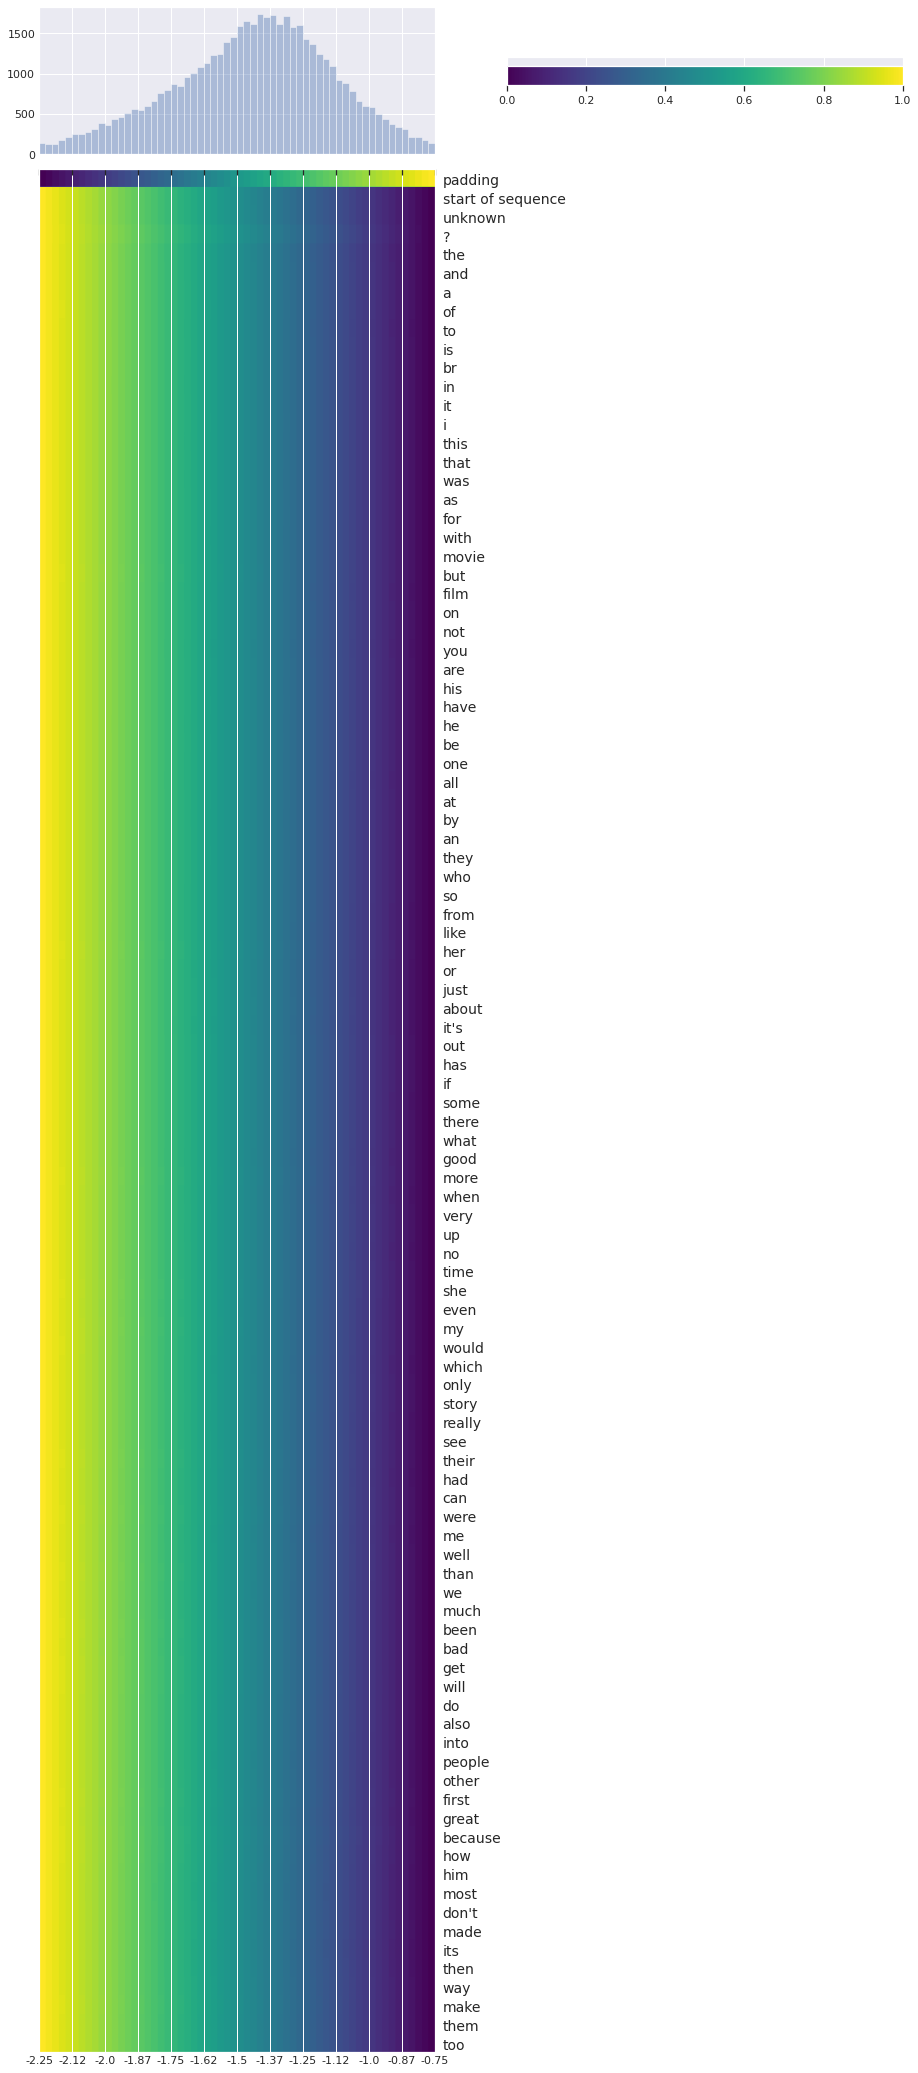

25000/25000 [==============================] - 14s 566us/sample - loss: 0.1605 - val_loss: 0.1355
Epoch 2/200
25000/25000 [==============================] - 0s 20us/sample - loss: 0.1410 - val_loss: 0.1344
Epoch 3/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1369 - val_loss: 0.1347
Epoch 4/200
25000/25000 [==============================] - 0s 20us/sample - loss: 0.1320 - val_loss: 0.1294
Epoch 5/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1305 - val_loss: 0.1292
Epoch 6/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1298 - val_loss: 0.1283
Epoch 7/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1296 - val_loss: 0.1287
Epoch 8/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1291 - val_loss: 0.1276
Epoch 9/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1286 - val_loss: 0.1277
Epoch 10/200
25000/25000 [============

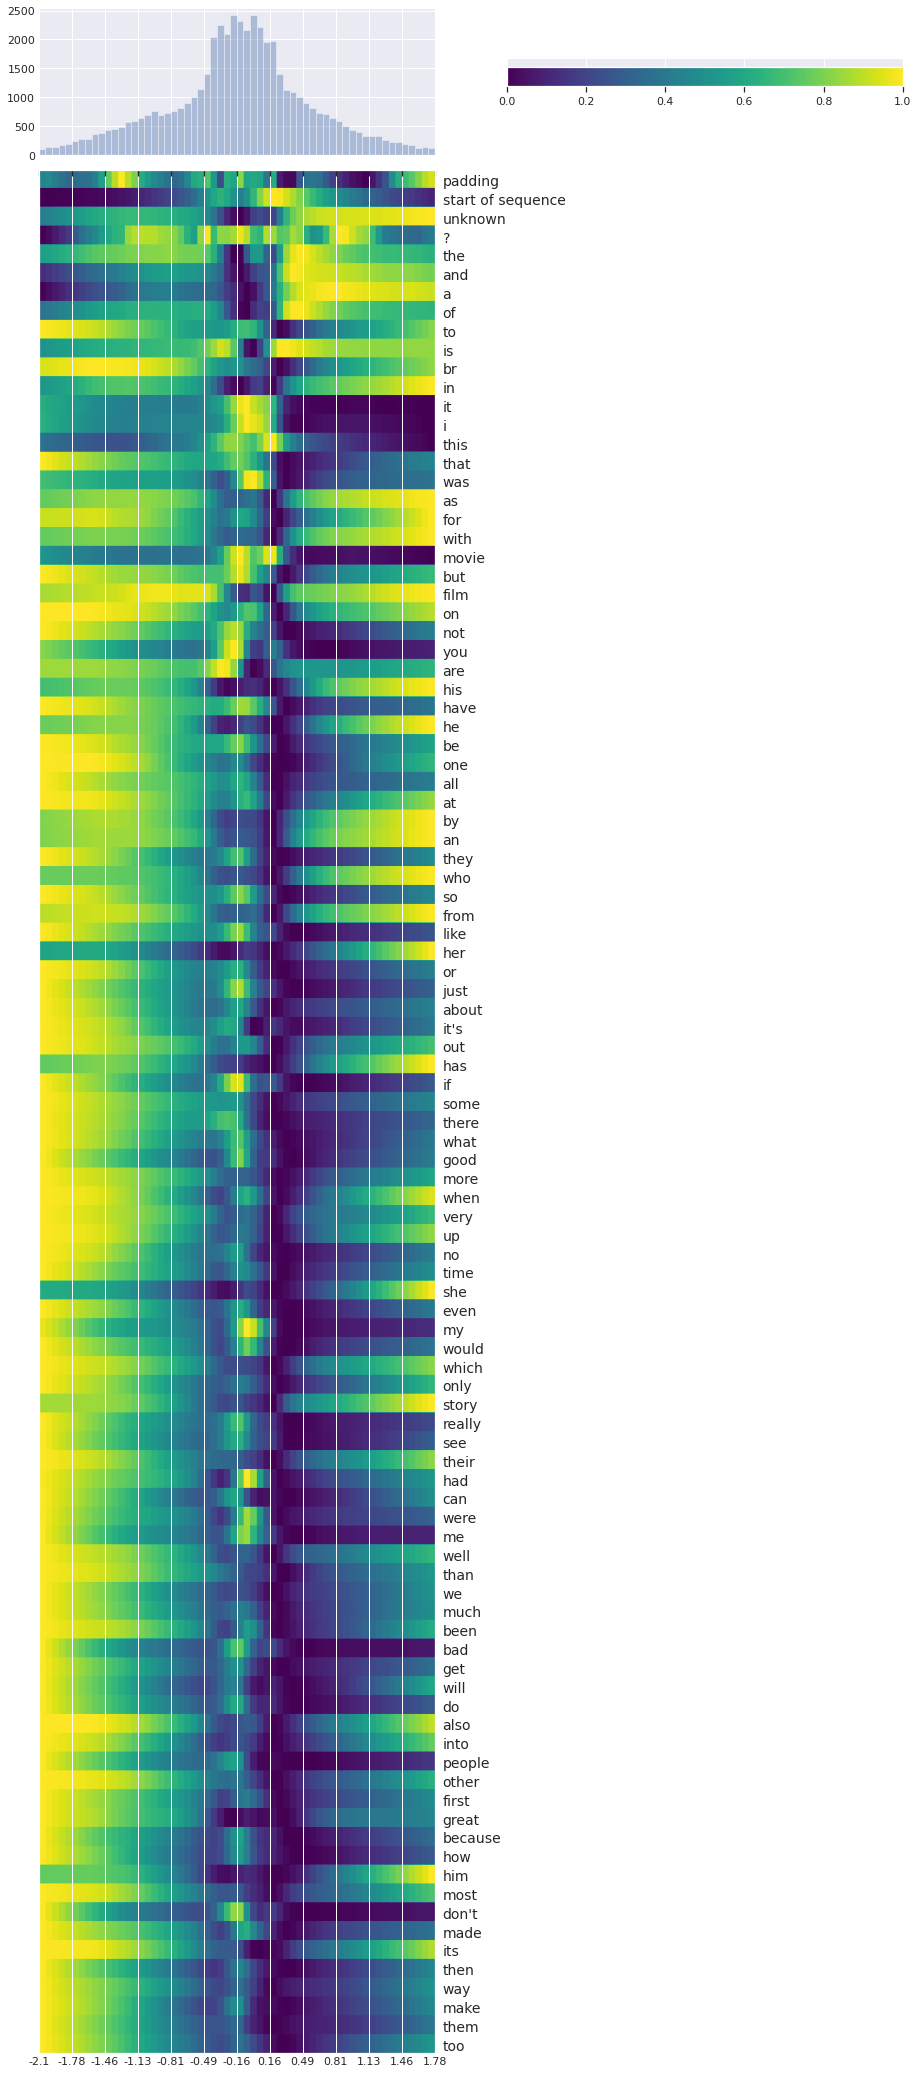

25000/25000 [==============================] - 6s 245us/sample - loss: 0.1251 - val_loss: 0.1238
Epoch 102/200
25000/25000 [==============================] - 0s 20us/sample - loss: 0.1253 - val_loss: 0.1238
Epoch 103/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1251 - val_loss: 0.1244
Epoch 104/200
25000/25000 [==============================] - 0s 18us/sample - loss: 0.1260 - val_loss: 0.1240
Epoch 105/200
25000/25000 [==============================] - 0s 18us/sample - loss: 0.1256 - val_loss: 0.1240
Epoch 106/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1249 - val_loss: 0.1241
Epoch 107/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1253 - val_loss: 0.1238
Epoch 108/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1251 - val_loss: 0.1237
Epoch 109/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1249 - val_loss: 0.1241
Epoch 110/200
25000/250

In [119]:
fitted = vae.fit(
    x=x_train, 
    y=None,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, None),
    callbacks = vae.callback_list
    )

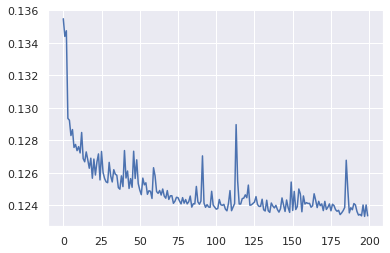

In [120]:
import matplotlib.pyplot as plt

plt.plot(fitted.history['val_loss'])

Train on 25000 samples, validate on 25000 samples
Epoch 1/200
21504/25000 [========================>.....] - ETA: 0s - loss: 0.1247

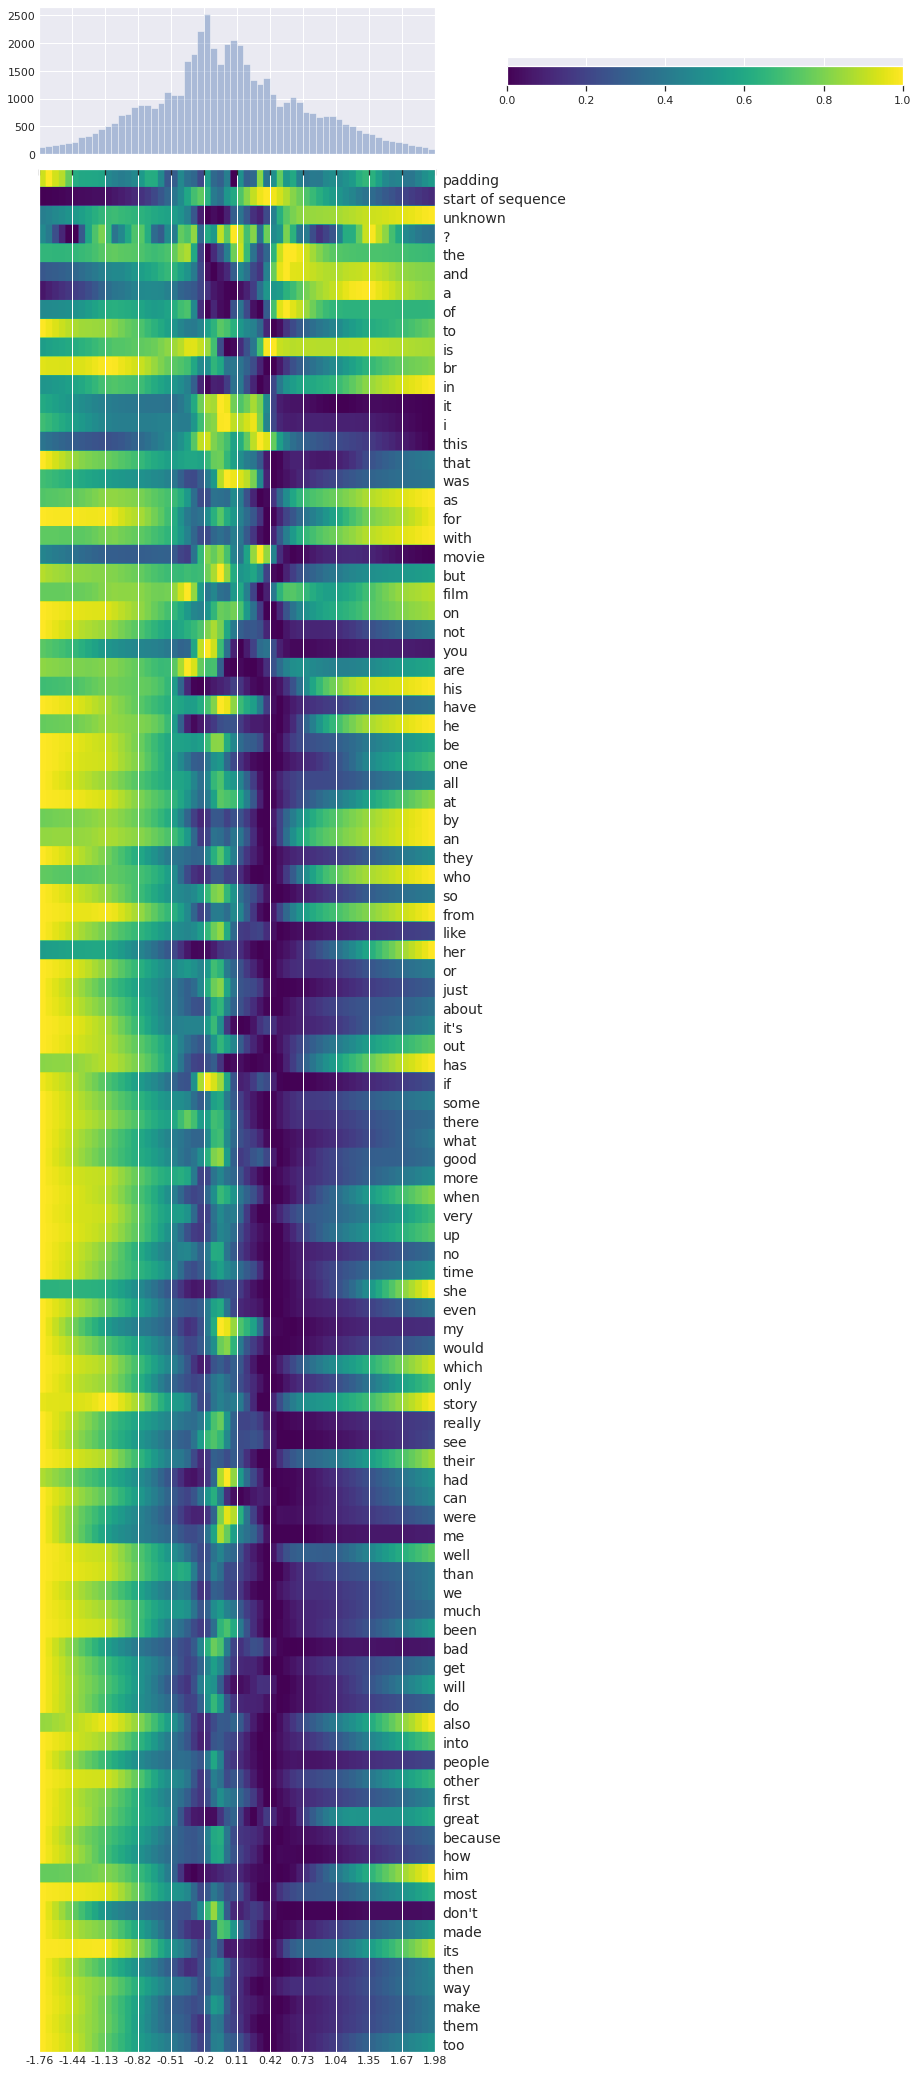

25000/25000 [==============================] - 6s 246us/sample - loss: 0.1246 - val_loss: 0.1233
Epoch 2/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1251 - val_loss: 0.1241
Epoch 3/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1265 - val_loss: 0.1238
Epoch 4/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1248 - val_loss: 0.1235
Epoch 5/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1249 - val_loss: 0.1239
Epoch 6/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1247 - val_loss: 0.1235
Epoch 7/200
25000/25000 [==============================] - 0s 18us/sample - loss: 0.1247 - val_loss: 0.1233
Epoch 8/200
25000/25000 [==============================] - 0s 18us/sample - loss: 0.1247 - val_loss: 0.1238
Epoch 9/200
25000/25000 [==============================] - 0s 18us/sample - loss: 0.1249 - val_loss: 0.1236
Epoch 10/200
25000/25000 [=============

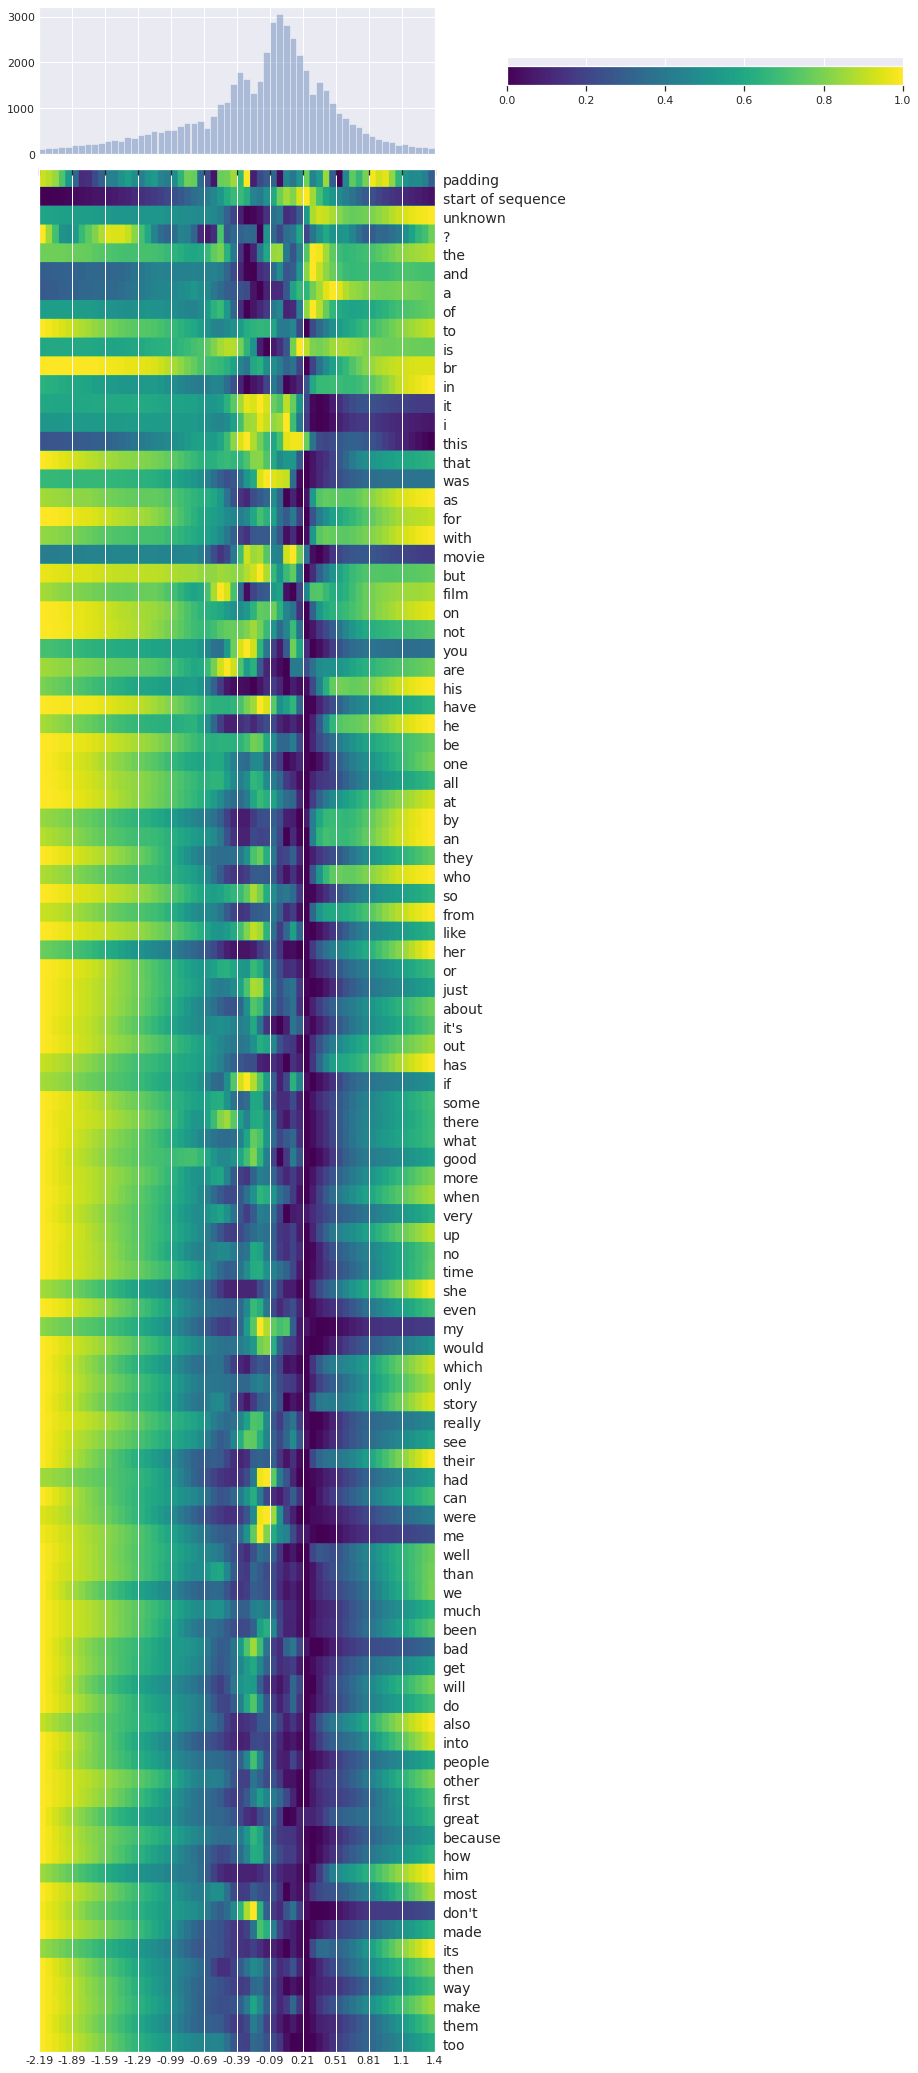

25000/25000 [==============================] - 6s 244us/sample - loss: 0.1246 - val_loss: 0.1231
Epoch 102/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1248 - val_loss: 0.1231
Epoch 103/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1246 - val_loss: 0.1244
Epoch 104/200
25000/25000 [==============================] - 0s 18us/sample - loss: 0.1249 - val_loss: 0.1231
Epoch 105/200
25000/25000 [==============================] - 0s 18us/sample - loss: 0.1242 - val_loss: 0.1230
Epoch 106/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1246 - val_loss: 0.1234
Epoch 107/200
25000/25000 [==============================] - 0s 18us/sample - loss: 0.1246 - val_loss: 0.1232
Epoch 108/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1244 - val_loss: 0.1246
Epoch 109/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1248 - val_loss: 0.1234
Epoch 110/200
25000/250

In [121]:
fitted = vae.fit(
    x=x_train, 
    y=None,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, None),
    callbacks = vae.callback_list
    )

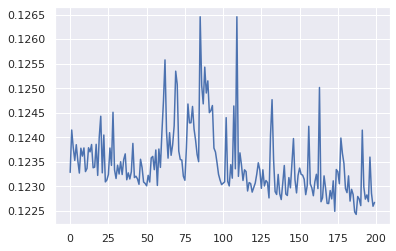

In [122]:
import matplotlib.pyplot as plt

plt.plot(fitted.history['val_loss'])

Train on 25000 samples, validate on 25000 samples
Epoch 1/200
21504/25000 [========================>.....] - ETA: 0s - loss: 0.1239

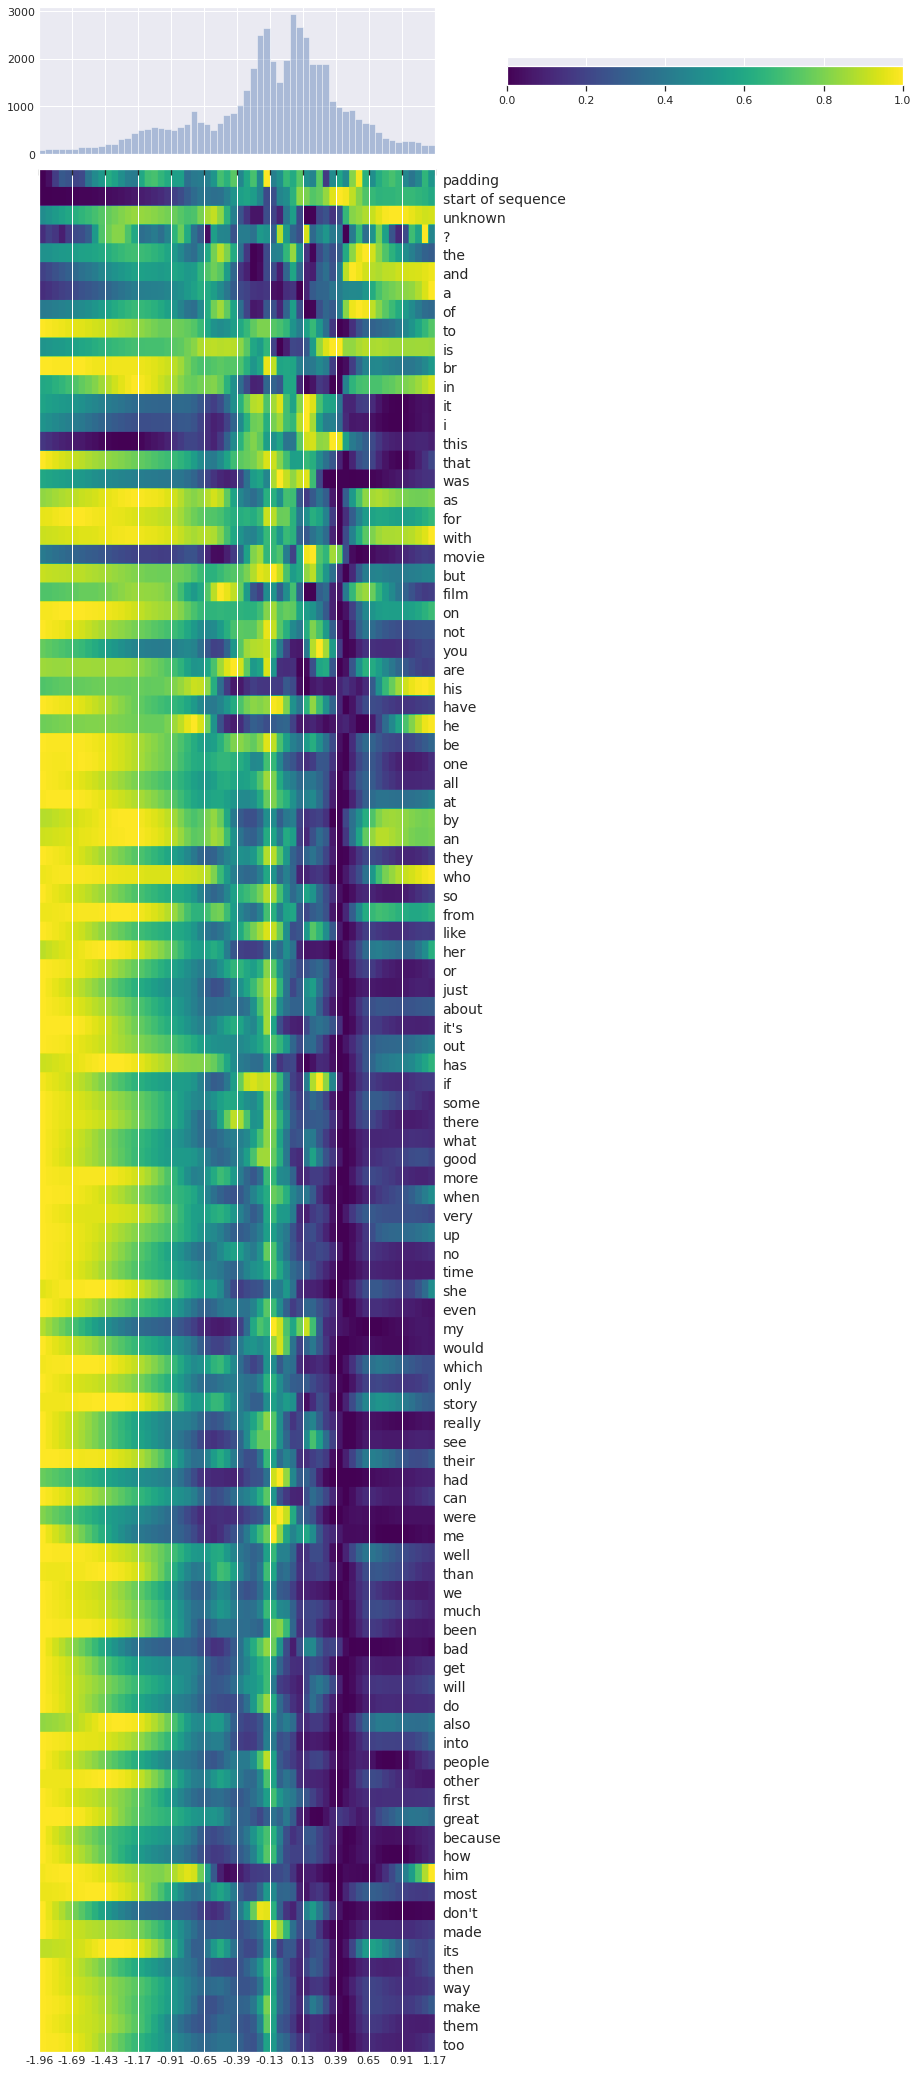

25000/25000 [==============================] - 6s 255us/sample - loss: 0.1240 - val_loss: 0.1231
Epoch 2/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1239 - val_loss: 0.1226
Epoch 3/200
25000/25000 [==============================] - 0s 18us/sample - loss: 0.1241 - val_loss: 0.1225
Epoch 4/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1239 - val_loss: 0.1227
Epoch 5/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1239 - val_loss: 0.1229
Epoch 6/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1243 - val_loss: 0.1229
Epoch 7/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1239 - val_loss: 0.1227
Epoch 8/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1240 - val_loss: 0.1226
Epoch 9/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1242 - val_loss: 0.1228
Epoch 10/200
25000/25000 [=============

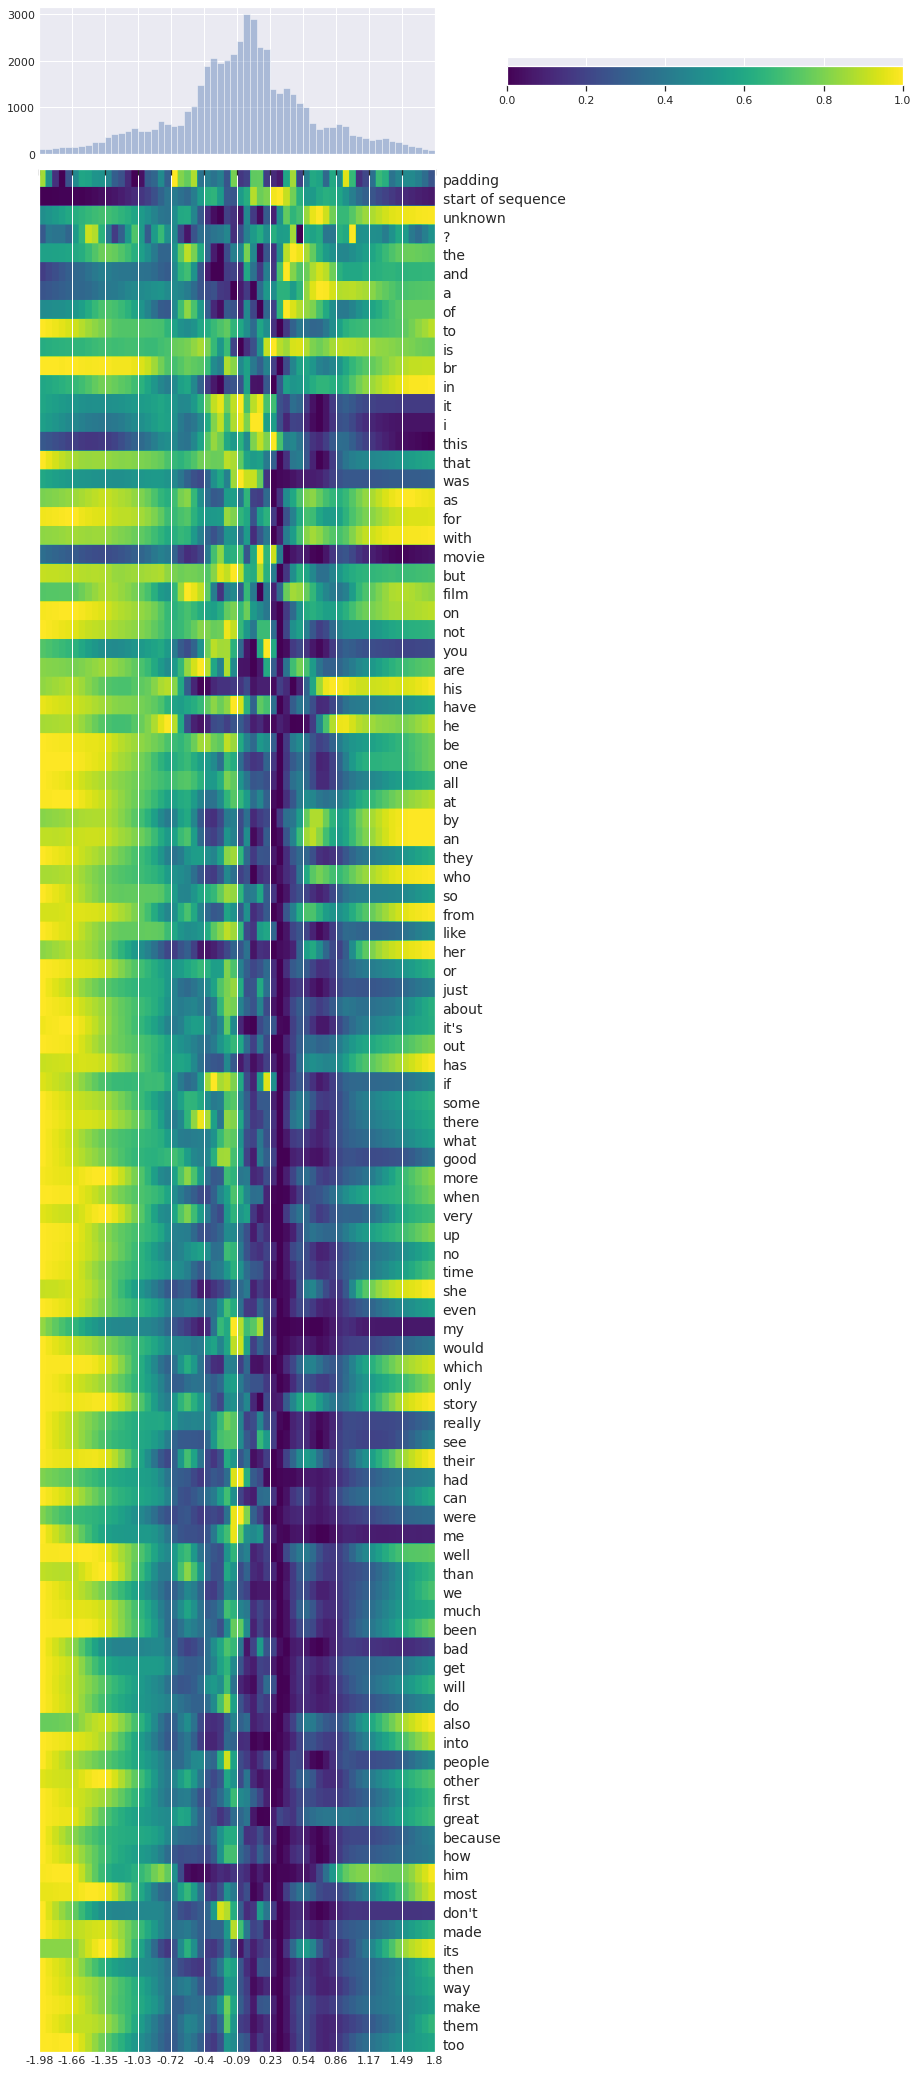

25000/25000 [==============================] - 6s 247us/sample - loss: 0.1234 - val_loss: 0.1222
Epoch 102/200
25000/25000 [==============================] - 0s 20us/sample - loss: 0.1234 - val_loss: 0.1221
Epoch 103/200
25000/25000 [==============================] - 0s 18us/sample - loss: 0.1235 - val_loss: 0.1226
Epoch 104/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1236 - val_loss: 0.1227
Epoch 105/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1235 - val_loss: 0.1222
Epoch 106/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1235 - val_loss: 0.1225
Epoch 107/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1235 - val_loss: 0.1223
Epoch 108/200
25000/25000 [==============================] - 0s 19us/sample - loss: 0.1236 - val_loss: 0.1222
Epoch 109/200
25000/25000 [==============================] - 0s 18us/sample - loss: 0.1235 - val_loss: 0.1223
Epoch 110/200
25000/250

In [123]:
fitted = vae.fit(
    x=x_train, 
    y=None,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, None),
    callbacks = vae.callback_list
    )

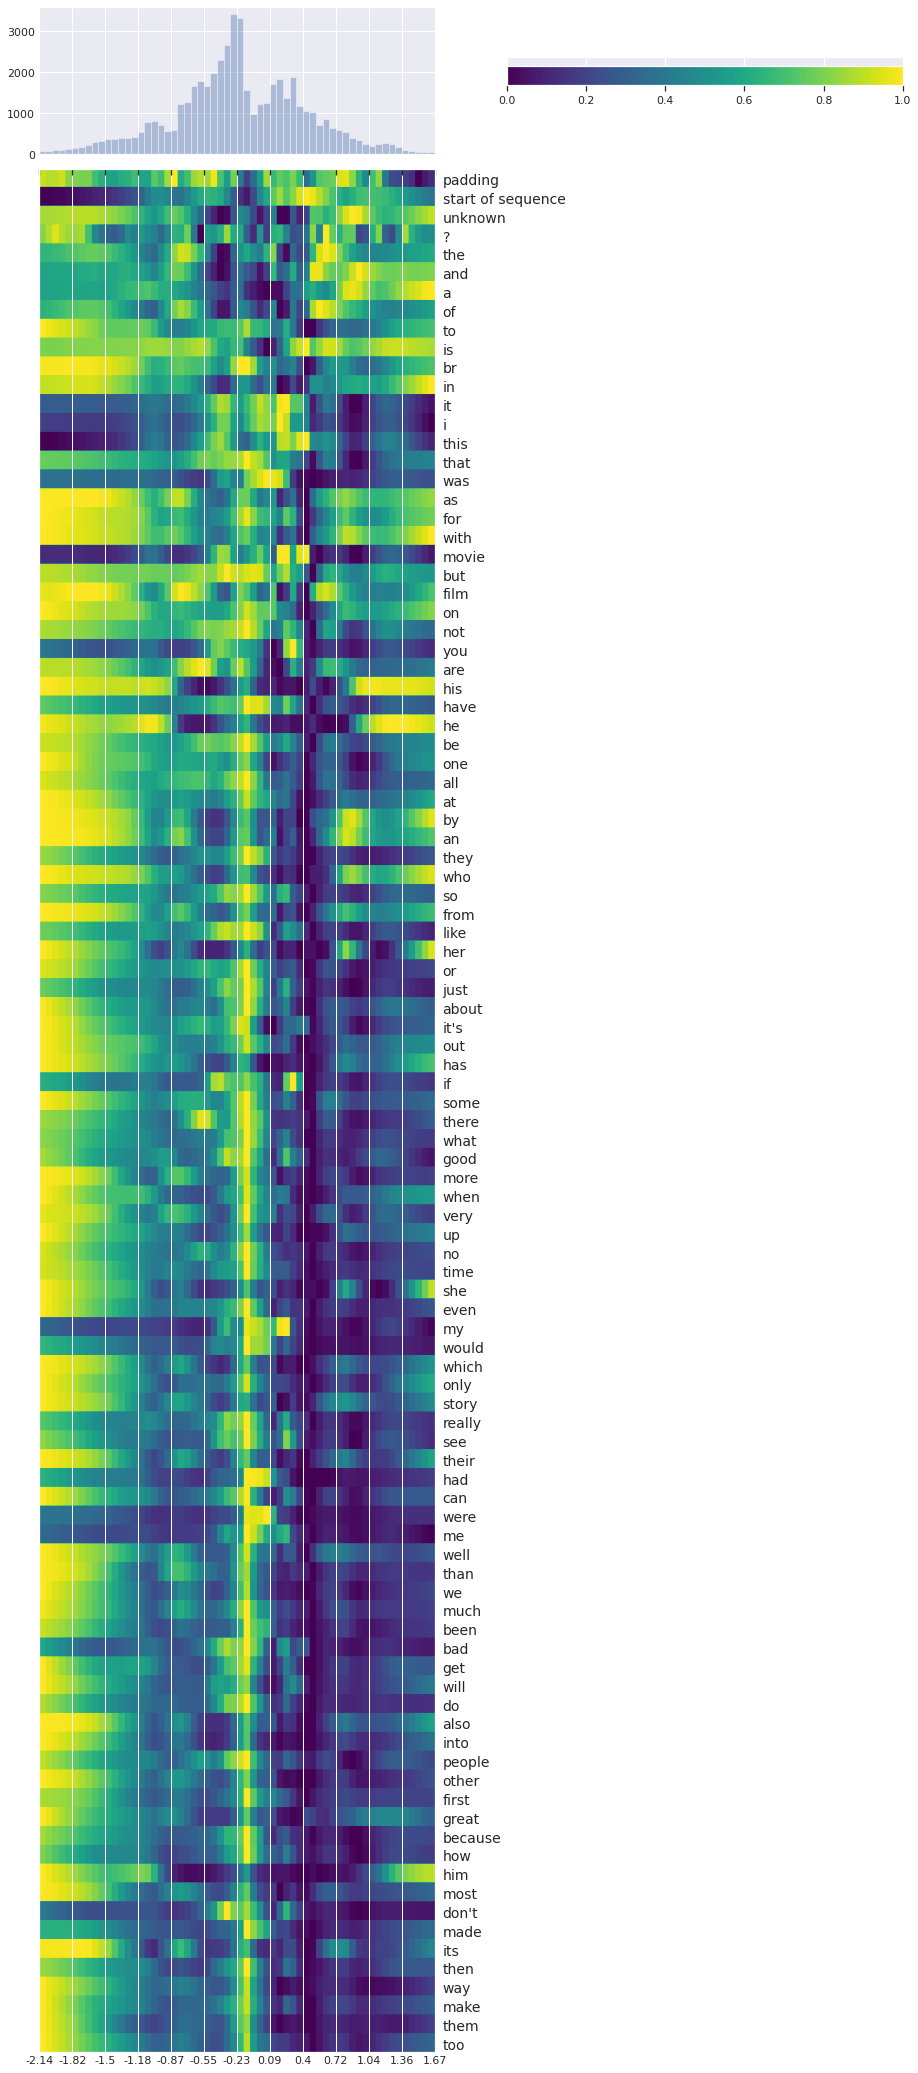

In [125]:

vnn.plot_types(encoder=vae.encoder,decoder=vae.decoder,data=qt.iloc[:,:n_features],
           n_activity=  100,  
           lowest_percentile=0.5, 
           highest_percentile=99.5, 
           figsize =(10, 41), 
           hist_size=0.05, spacing= -0.001);

In [127]:
flag_1 = np.ones((qt.iloc[:,:n_features].shape[0],1),dtype=qt.values.dtype)
data = np.concatenate((qt.iloc[:,:n_features].values,flag_1),axis=-1)
encoded_data=pd.DataFrame(vae.encoder.predict(data))
encoded_data

,0
0,-0.358161
1,-0.573098
2,0.028799
3,-1.612444
4,0.225228
...,...
49995,-0.158903
49996,0.517063
49997,-0.448508
49998,0.181176


In [128]:
reviews = pd.DataFrame(np.concatenate([y_train,y_test],axis=0))
reviews

,0
0,1.0
1,0.0
2,0.0
3,1.0
4,0.0
...,...
49995,1.0
49996,1.0
49997,0.0
49998,0.0


In [129]:
joint = pd.DataFrame( np.concatenate([encoded_data.values, 
                                      reviews.values],axis=1))
joint.columns = ['Encoded','Good']
joint

,Encoded,Good
0,-0.358161,1.0
1,-0.573098,0.0
2,0.028799,0.0
3,-1.612444,1.0
4,0.225228,0.0
...,...,...
49995,-0.158903,1.0
49996,0.517063,1.0
49997,-0.448508,0.0
49998,0.181176,0.0


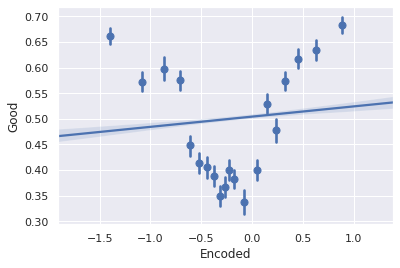

In [134]:
 import seaborn as sns
 
 ax= sns.regplot(x='Encoded', y='Good', data=joint, 
                 x_bins=20)
 
 ax.set_xlim(np.percentile(encoded_data, 1),
             np.percentile(encoded_data, 99));
 
 
             